In [151]:
%matplotlib inline

import numpy as np
import edward as ed
import pandas as pd
from time import time
import tensorflow as tf
from edward.models import Categorical, Normal
from keras.utils import to_categorical

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample

plt.style.use('ggplot')

In [11]:
## Sklearn related modules
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [12]:
random_seed = 2018

In [13]:
ed.set_seed(random_seed)

In [14]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.facecolor':'white',
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [15]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [16]:
df = shuffle(df_train_all, random_state = random_seed)
df_train = shuffle(df_train, random_state = random_seed)
df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)


### Class Balance

In [17]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [18]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [19]:
df_minor.shape[0]

559

In [20]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 2018)

In [21]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [23]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Fetaure Scaling

In [24]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

### Model prior weights

In [25]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

In [26]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

### Define model prior

In [27]:
with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)     

### Inference

In [28]:
with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)   

In [29]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

In [30]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, 
                    data={X: xtrain, 
                          y: ytrain})

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.05

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.3, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

inference.run(n_iter=20000, optimizer=optimizer, global_step=global_step)

/Users/sabber/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


20000/20000 [100%] ██████████████████████████████ Elapsed: 33s | Loss: 2160.378


In [34]:
n_samples = 1000

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
print("Took", np.int(time() - t0), "secs.")

Preparing to sample...
Took 15 secs.
Sampling...
Took 8 secs.


In [64]:
predictions_samp = samplepredictions[:, :, 0]

In [152]:

sns.set(color_codes=True)

def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde=False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

In [35]:
probs = []
centers = []

for i in range(len(xtest)):
    histogram = np.histogram(samplepredictions[:,i], bins=20)
    probs.append(histogram[0] / n_samples)
    delta = histogram[1][1] - histogram[1][0]
    centers.append([np.float32(a + delta / 2) for a in histogram[1][:-1]])

In [36]:
from edward.models import Categorical, Mixture
y_post = []

t0 = time()
for i in range(len(xtest)):
    print("Forming the posterior predictive distribution for test data point", i+1, "/", len(xtest), "...")
    y_post.append(Mixture(Categorical(probs = probs[i]), 
                  [Normal(loc=centers[i][j], scale=1.0) for j in range(len(centers[i]))]))
    
print("Took altogether", np.int(time() - t0), "secs.")

Forming the posterior predictive distribution for test data point 1 / 400 ...
Forming the posterior predictive distribution for test data point 2 / 400 ...
Forming the posterior predictive distribution for test data point 3 / 400 ...
Forming the posterior predictive distribution for test data point 4 / 400 ...
Forming the posterior predictive distribution for test data point 5 / 400 ...
Forming the posterior predictive distribution for test data point 6 / 400 ...
Forming the posterior predictive distribution for test data point 7 / 400 ...
Forming the posterior predictive distribution for test data point 8 / 400 ...
Forming the posterior predictive distribution for test data point 9 / 400 ...
Forming the posterior predictive distribution for test data point 10 / 400 ...
Forming the posterior predictive distribution for test data point 11 / 400 ...
Forming the posterior predictive distribution for test data point 12 / 400 ...
Forming the posterior predictive distribution for test data p

In [37]:
t0 = time()
print("Sampling the posterior predictive distribution for", len(xtest), "test data points...")
posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(len(xtest))], axis=1)
posteriorsamples = pd.DataFrame(posteriorsamplenodes.eval())
print("Took", np.int(time() - t0), "secs.")

Sampling the posterior predictive distribution for 400 test data points...
Took 2170 secs.


In [134]:
results = pd.DataFrame()
results['target'] = list(ytest)

In [135]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['pred_std'] = predictions_samp.std(axis = 0)
results['pred_var'] = predictions_samp.var(axis = 0)

In [136]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['pred_std'])
# np.transpose(zzz)[:, 0]
results['confidence_low'] = np.transpose(zzz)[:, 0]
results['confidence_high'] = np.transpose(zzz)[:, 1]
results['confidence_range'] = np.absolute(results['confidence_high'] - results['confidence_low'])

In [137]:
ypred = []
for pred in results['predictions']:
    if pred > 0.5:
        ypred.append(1)
    else:
        ypred.append(0)

In [138]:
results['bin_pred'] = ypred

In [143]:
correct = results[(results.target == results.bin_pred)]

In [144]:
incorrect = results[(results.target != results.bin_pred)]

In [162]:
correct.columns

Index(['target', 'predictions', 'pred_std', 'pred_var', 'confidence_low',
       'confidence_high', 'confidence_range', 'bin_pred'],
      dtype='object')

In [167]:
incorrect.predictions[(incorrect.bin_pred == 0)].mean(axis = 0)

0.06273868680000305

In [169]:
correct.predictions[(correct.bin_pred == 0)].mean(axis = 0)

0.2775301933288574

In [170]:
correct.head(10)

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
0,[0.0],0.255379,0.097364,0.009480,0.064549,0.446209,0.381659,0
1,[1.0],0.941344,0.049162,0.002417,0.844988,1.037700,0.192712,1
2,[0.0],0.219974,0.139833,0.019553,-0.054093,0.494041,0.548134,0
3,[0.0],0.268271,0.123672,0.015295,0.025878,0.510664,0.484785,0
4,[1.0],0.625211,0.205229,0.042119,0.222969,1.027452,0.804483,1
5,[0.0],0.263103,0.091459,0.008365,0.083846,0.442359,0.358513,0
6,[1.0],0.563176,0.115885,0.013429,0.336045,0.790307,0.454262,1
7,[0.0],0.242869,0.100733,0.010147,0.045436,0.440301,0.394865,0
8,[0.0],0.272457,0.087893,0.007725,0.100189,0.444725,0.344535,0
9,[0.0],0.239843,0.111855,0.012512,0.020611,0.459074,0.438463,0


In [171]:
incorrect.head(10)

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
11,[0.0],0.604984,0.140548,0.019754,0.329514,0.880453,0.550939,1
18,[1.0],0.489839,0.115475,0.013335,0.263512,0.716166,0.452654,0
23,[0.0],0.676808,0.198931,0.039574,0.286909,1.066706,0.779797,1
36,[1.0],0.432259,0.177176,0.031391,0.085000,0.779518,0.694518,0
38,[0.0],0.665777,0.194176,0.037704,0.285199,1.046355,0.761156,1
42,[0.0],0.629658,0.227872,0.051926,0.183037,1.076278,0.893241,1
45,[0.0],0.502172,0.199347,0.039739,0.111460,0.892884,0.781424,1
49,[1.0],0.437930,0.153794,0.023653,0.136500,0.739361,0.602861,0
51,[0.0],0.504720,0.193459,0.037426,0.125547,0.883893,0.758346,1
66,[1.0],0.275402,0.143836,0.020689,-0.006511,0.557315,0.563826,0


/Users/sabber/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


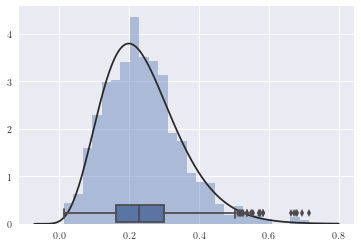

In [173]:
plot_distribution(9)

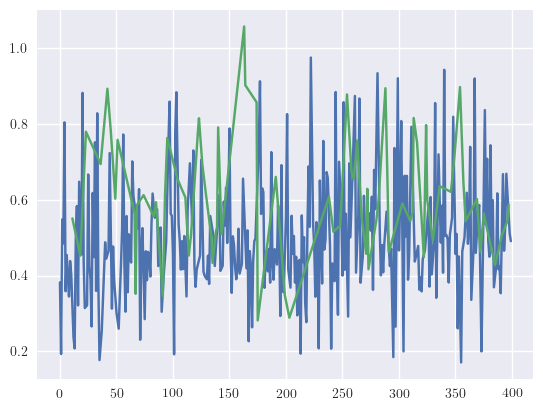

In [147]:
plt.plot(correct.confidence_range)
plt.plot(incorrect.confidence_range)
plt.show()

In [86]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [87]:
def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [88]:
prediction(ytest, ypred)

Accuracy of the model: 0.8075

Classification report: 
             precision    recall  f1-score   support

        0.0       0.91      0.80      0.85       272
        1.0       0.66      0.83      0.73       128

avg / total       0.83      0.81      0.81       400


Confusion matrix: 
[[217  55]
 [ 22 106]]



In [39]:
import sys
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []

w_0_samples = []
b_0_samples = []
w_1_samples = []
b_1_samples = []

for _ in range(n_samples):
    w_0_samp = qW_0.sample()
    b_0_samp = qb_0.sample()
    w_1_samp = qW_1.sample()
    b_1_samp = qb_1.sample()
    
    w_0_samples.append(w_0_samp)
    w_1_samples.append(w_1_samp)
    b_0_samples.append(b_0_samp)
    b_1_samples.append(b_1_samp)
    
    # prediction on test data
    h = tf.nn.relu(tf.matmul(xtest.astype('float32'), w_0_samp) + b_0_samp)
    y_pred = tf.nn.sigmoid(tf.matmul(h, w_1_samp) + b_1_samp)
    
    ## Probability calculation using softmax
    prob = tf.nn.softmax(y_pred)
    prob_lst.append(y_pred.eval())
    
#     sample = tf.concat([tf.reshape(w_samp,[-1]), b_samp],0)
#     samples.append(sample.eval())

In [34]:
np.shape(prob_lst)

(100, 400, 2)

Text(0,0.5,'Frequency')

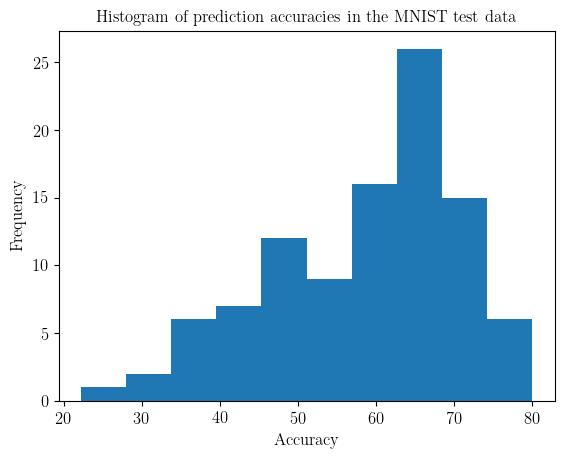

In [40]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    ytest2 = np.argmax(ytest, axis=1).astype(np.float32)
    
    acc = (y_trn_prd == ytest2).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")